In [ ]:
import pandas as pd

In [ ]:
"""
1) Reading the raw training data
2) Figured that the only column with NULL is the snow_depth column and most of its values are 0. Hence filling with mode=0
3) Dropping date and time cause they dont have any impact on the fire - Seasonality trends are taken care of by weather variables
"""
training_df=pd.read_csv("training_df_raw.csv")
training_df.fillna(0,inplace=True)
training_df.drop(['date','time'],axis=1,inplace=True)
training_df.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,...,wind_gusts_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,fire
0,10.4600,95.42882,9.7600,9.326071,0.0,0.0,0.0,0.0,0.0,1012.4,...,11.879999,10.7600,13.110001,14.0100,21.910000,0.275,0.318,0.195,0.026,1.0
1,10.4535,95.42859,9.7535,9.317741,0.0,0.0,0.0,0.0,0.0,1012.4,...,11.879999,10.7535,13.103500,14.0035,21.903500,0.275,0.318,0.195,0.026,1.0
2,10.4145,95.42721,9.7145,9.267784,0.0,0.0,0.0,0.0,0.0,1012.4,...,11.879999,10.7145,13.064501,13.9645,21.864500,0.275,0.318,0.195,0.026,1.0
3,9.2235,99.66392,9.1735,8.143780,0.0,0.0,0.0,0.0,0.0,1012.5,...,13.320000,10.4235,12.823500,13.7235,21.923500,0.273,0.324,0.201,0.020,1.0
4,9.2430,99.66399,9.1930,8.168585,0.0,0.0,0.0,0.0,0.0,1012.5,...,13.320000,10.4430,12.842999,13.7430,21.942999,0.273,0.324,0.201,0.020,1.0


In [ ]:
training_df.shape

(105547, 31)

In [ ]:
X=training_df.drop('fire',axis=1)
y=training_df['fire']

In [ ]:
"""
Standard Scaling for the numerical variables cause every column is in different units - Centigrade, centimeter, millimeter etc
"""
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

def feature_transformation(encode_df):
    num_attributes=encode_df.columns.to_list()
    numeric_pipeline=Pipeline([
        ('std_scaler',StandardScaler())
    ])
    encoder_pipeline=ColumnTransformer([
        ("numeric_var",numeric_pipeline,num_attributes),
    ])
    df_encoded=encoder_pipeline.fit_transform(encode_df)
    return df_encoded,encoder_pipeline
X_transformed=feature_transformation(X)

Feature Importance

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42,n_jobs=-1,verbose=True)
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.0s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=True)

In [ ]:
"""
Built a random forest model and displayed the best features based on Gini Importance
"""
importances = rf.feature_importances_
feature_names=X.columns
feature_imp_df = pd.DataFrame({'Feature': X.columns.tolist(), 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
feature_imp_df

,Feature,Gini Importance
15,et0_fao_evapotranspiration,0.110268
22,soil_temperature_0_to_7cm,0.070946
23,soil_temperature_7_to_28cm,0.059189
1,relative_humidity_2m,0.045872
17,wind_speed_10m,0.044297
10,surface_pressure,0.043850
21,wind_gusts_10m,0.043725
20,wind_direction_100m,0.042779
18,wind_speed_100m,0.042682
19,wind_direction_10m,0.042535


In [ ]:
"""
Analytically - The features with lower importance involve cloud cover, weather code, rain, snow.
Intuitively - You would expect rain, snow, weather code or cloud cover to have an effect on fire
"""
unimportant_features=feature_imp_df[feature_imp_df['Gini Importance']<(2/100)]['Feature'].tolist()

In [ ]:
"""
This is an optional step because since we have only about 31 features, the only advantage of dropping features that are highly correlated is the increase in model building time
and not really the accuracy as seen below in the evaluation metrics. The AUC scores are pretty much the same
"""
high_correlated_features=['soil_temperature_7_to_28cm','wind_direction_10m','temperature_2m','soil_moisture_28_to_100cm',
                          'soil_moisture_7_to_28cm','soil_temperature_100_to_255cm','soil_temperature_28_to_100cm',
                          'soil_temperature_100_to_255cm','soil_moisture_100_to_255cm']

In [ ]:
drop_features=unimportant_features+high_correlated_features

In [ ]:
X.drop(drop_features,axis=1,inplace=True)

In [ ]:
X.shape

(105547, 13)

K FOLD CROSS VALIDATION - HELPS FIGURE OUT THE BEST MODEL ON AVERAGE WITHOUT ANY HYPERPARAMETER TUNING

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb

classifiers = {
    "Random Forest": RandomForestClassifier(n_jobs=-1),
    "SVM": SVC(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1),
    "LightGBM": lgb.LGBMClassifier(n_jobs=-1),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_jobs=-1)
}



In [ ]:
import numpy as np

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_train, y_train, cv=kf, scoring='accuracy')
    results[name] = scores

# Print results
for name, scores in results.items():
    print(f"{name}: Mean Accuracy = {np.mean(scores):.4f}, Std Dev = {np.std(scores):.4f}")


Random Forest: Mean Accuracy = 0.8413, Std Dev = 0.0023
SVM: Mean Accuracy = 0.5859, Std Dev = 0.0080
XGBoost: Mean Accuracy = 0.8223, Std Dev = 0.0014
LightGBM: Mean Accuracy = 0.7895, Std Dev = 0.0040
Naive Bayes: Mean Accuracy = 0.5432, Std Dev = 0.0163
KNN: Mean Accuracy = 0.7282, Std Dev = 0.0041


In [ ]:
"""
Using Randomized Search CV for hyperparameter tuning
"""
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()

# 3. Set up the parameter grid
param_dist = {
    'n_estimators': np.arange(50, 300, 10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None] + list(np.arange(10, 110, 10)),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 5),
    'bootstrap': [True, False]
}
param_dist

{'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
        180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290]),
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
 'min_samples_leaf': array([1, 2, 3, 4]),
 'bootstrap': [True, False]}

In [ ]:
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=param_dist,
                               n_iter=100,
                               cv=3,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)

rf_random.fit(X, y)

best_rf = rf_random.best_estimator_
print("Best parameters found: ", rf_random.best_params_)
print("Best score: ", rf_random.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
111 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", 

Best parameters found:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
Best score:  0.6390040386712302


In [ ]:
best_params=  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True,'n_jobs':-1}


Model Building

In [ ]:
rf = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                            min_samples_split=best_params['min_samples_split'],
                            min_samples_leaf=best_params['min_samples_leaf'],
                            max_features=best_params['max_features'],
                            max_depth=best_params['max_depth'],
                            bootstrap=best_params['bootstrap'],
                            n_jobs=best_params['n_jobs'])

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200, n_jobs=-1)

In [34]:
# from sklearn.tree import export_graphviz
# tree = rf.estimators_[0]
# dot_data = export_graphviz(tree, out_file=None)
# graph = graphviz.Source(dot_data)
# graph

Evaluation

In [ ]:
y_pred=rf.predict(X_test)
y_scores = rf.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report)
import matplotlib.pyplot as plt

In [ ]:
# Before Dropping unimportant Features
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.69      0.75     11258
           1       0.74      0.84      0.79     11522

    accuracy                           0.77     22780
   macro avg       0.77      0.77      0.77     22780
weighted avg       0.77      0.77      0.77     22780



In [ ]:
# After dropping unimportant features
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.69      0.75     11258
           1       0.74      0.86      0.80     11522

    accuracy                           0.78     22780
   macro avg       0.78      0.78      0.77     22780
weighted avg       0.78      0.78      0.77     22780



In [ ]:
# After dropping unimportant and highly correlated features
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.61      0.70      9596
         1.0       0.73      0.88      0.80     11514

    accuracy                           0.76     21110
   macro avg       0.77      0.75      0.75     21110
weighted avg       0.77      0.76      0.75     21110



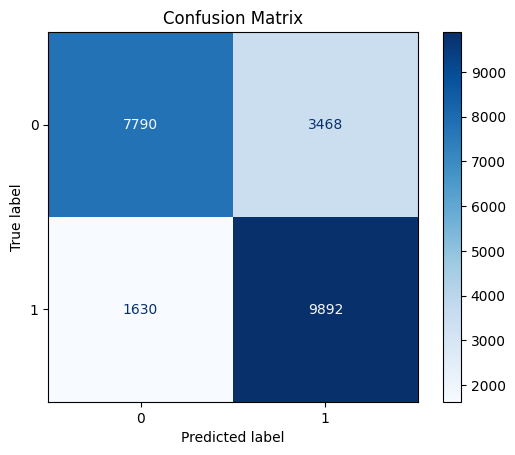

In [ ]:
# After dropping unimportant and highly correlated features
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

AUC-ROC Score: 0.8328579257192957


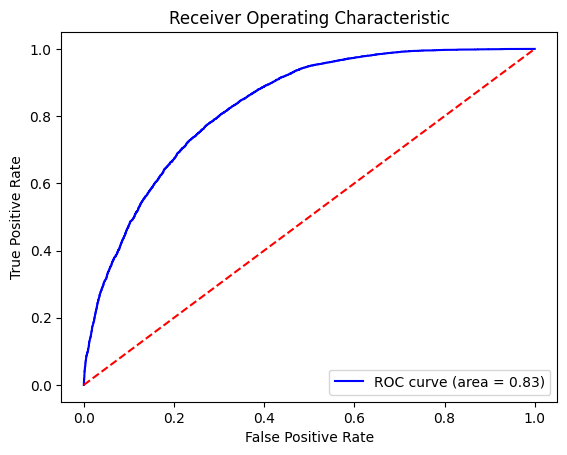

In [ ]:
auc_score = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_score)


fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()